In [17]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
data = pd.read_csv("data1.csv")
data['stats'] = data['stats'].apply(ast.literal_eval)
stats_df = pd.json_normalize(data['stats'])
data = pd.concat([data.drop(columns=['stats']), stats_df], axis=1)

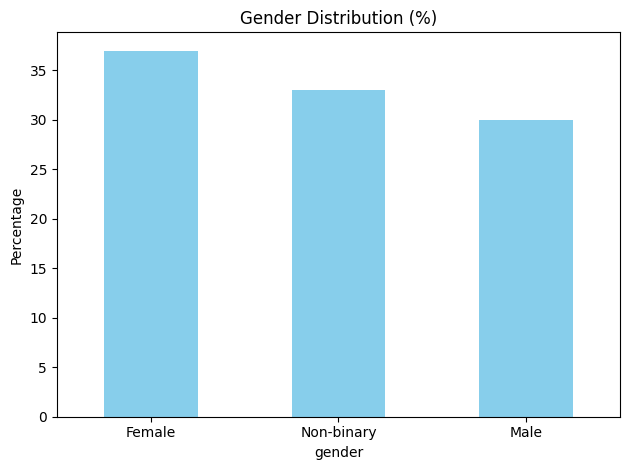

In [19]:
gender_counts = data['gender'].value_counts(normalize=True) * 100
gender_counts.plot(kind='bar', title='Gender Distribution (%)', color='skyblue')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

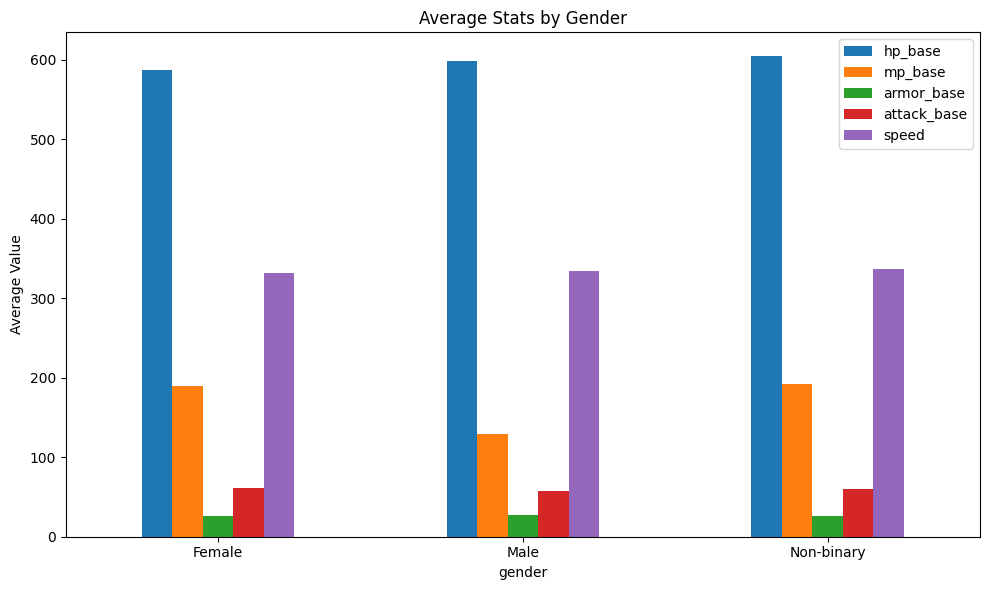

In [21]:
gender_stats = data.groupby('gender')[['hp_base', 'mp_base', 'armor_base', 'attack_base', 'speed']].mean()
gender_stats.plot(kind='bar', figsize=(10, 6), title='Average Stats by Gender')
plt.ylabel('Average Value')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

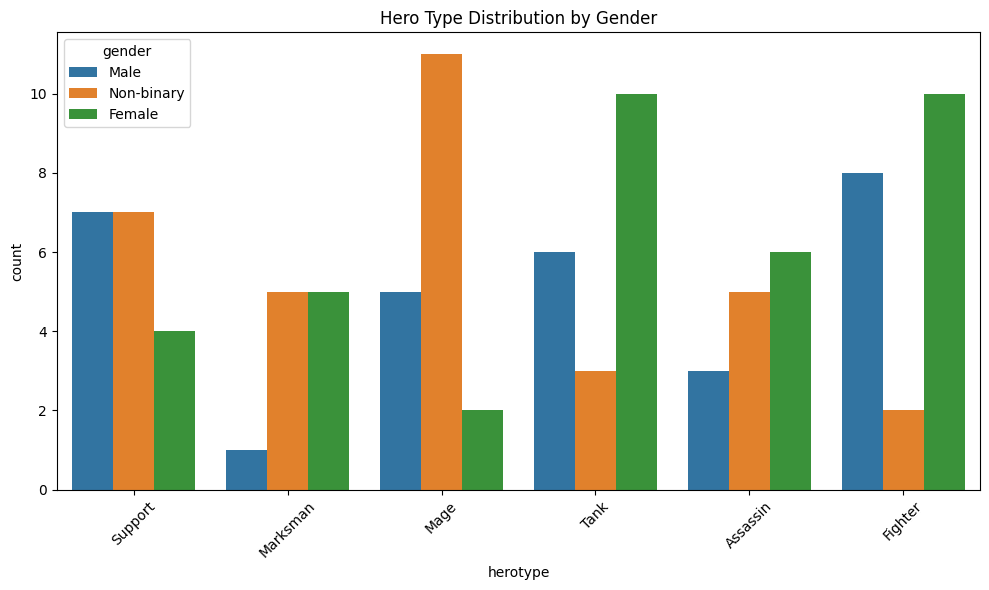

In [23]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='herotype', hue='gender')
plt.title('Hero Type Distribution by Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

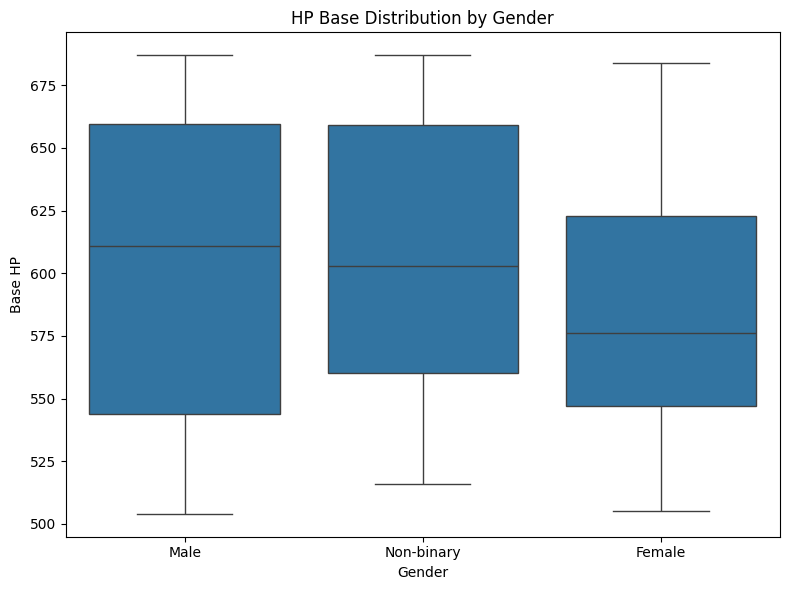

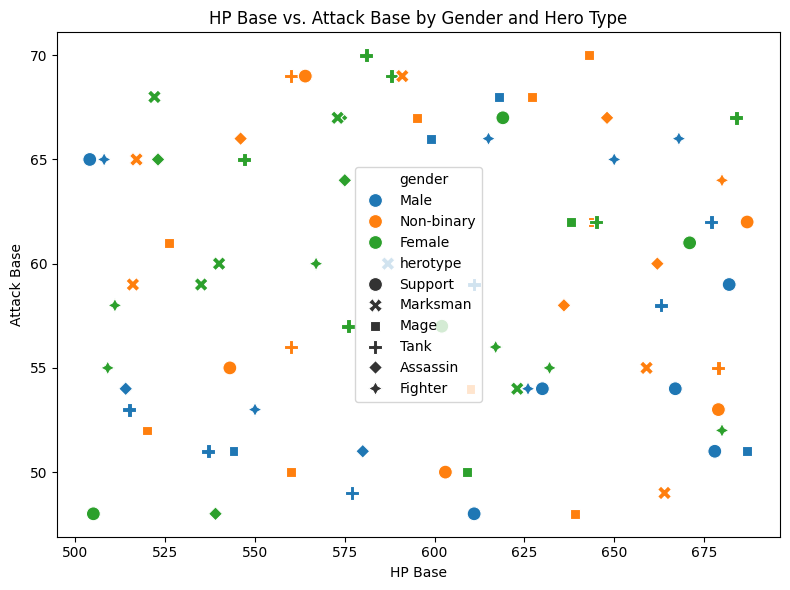

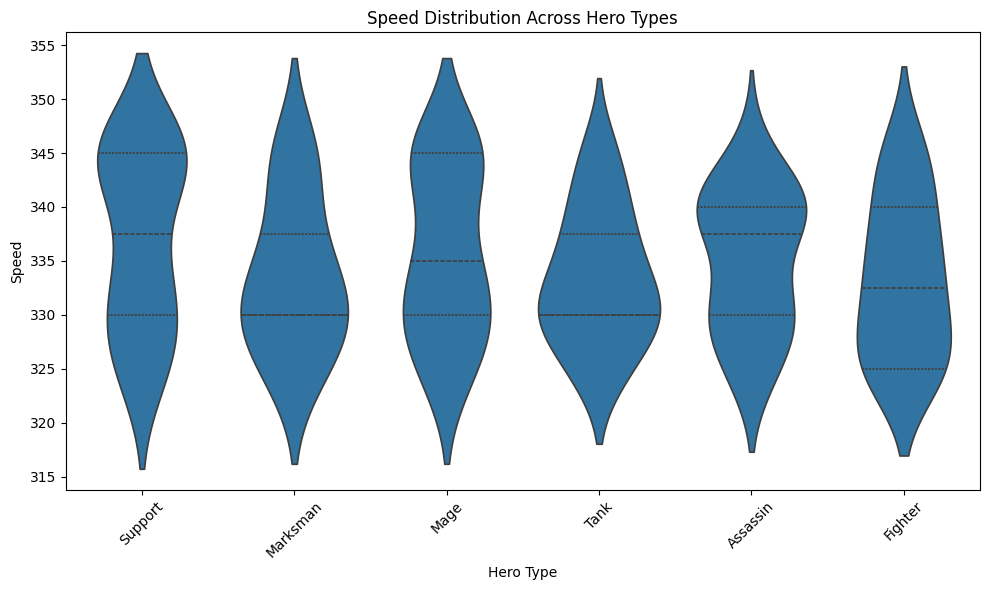

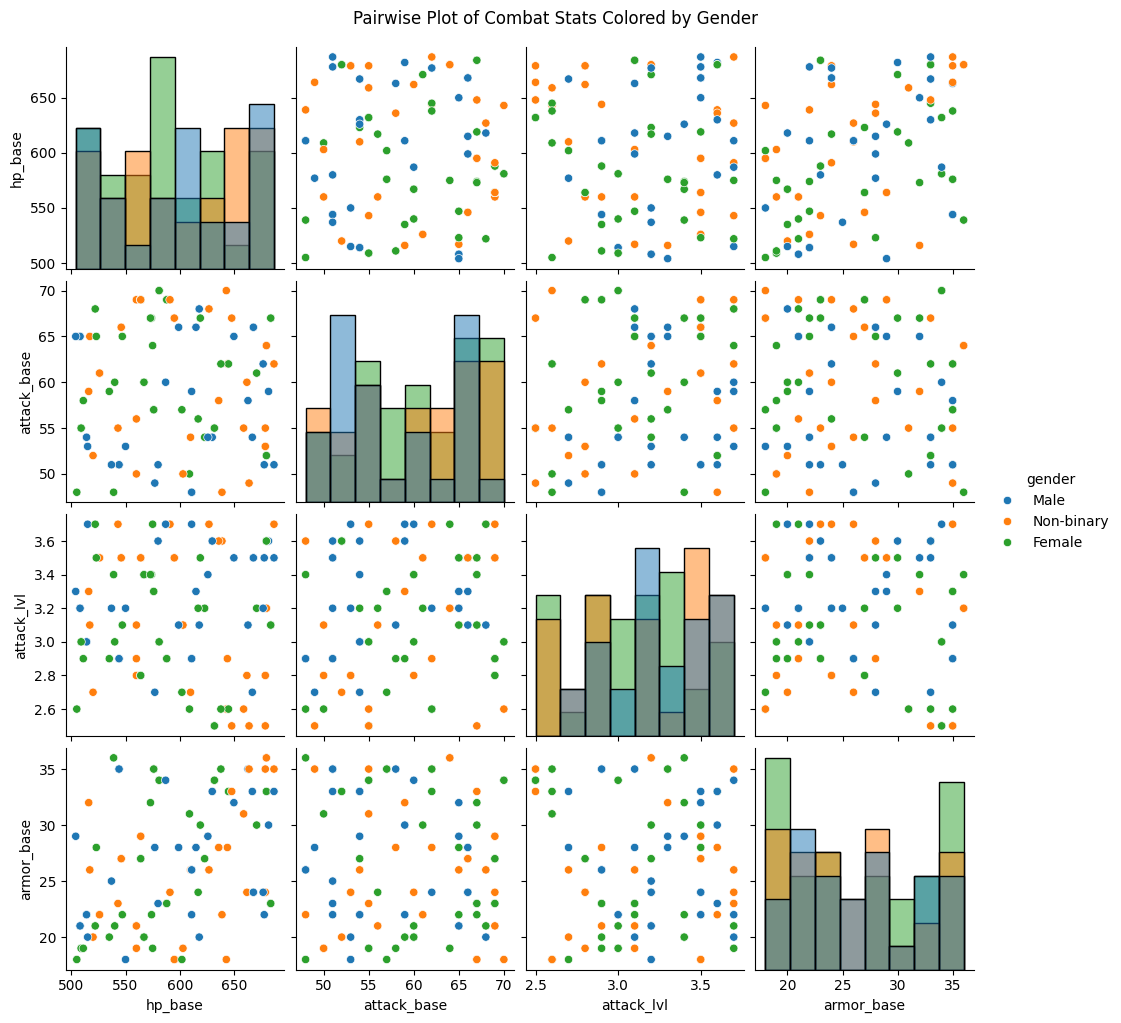

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
df = pd.read_csv("data1.csv")
df['gender'] = df['gender'].str.strip()
df['herotype'] = df['herotype'].str.strip()
df['alttype'] = df['alttype'].str.strip()
df['rangetype'] = df['rangetype'].str.strip()
df['race'] = df['race'].str.strip()
df['parsed_stats'] = df['stats'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else {})
stats_df = pd.json_normalize(df['parsed_stats'])
df_stats = pd.concat([df, stats_df], axis=1)
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_stats, x='gender', y='hp_base')
plt.title('HP Base Distribution by Gender')
plt.ylabel('Base HP')
plt.xlabel('Gender')
plt.tight_layout()
plt.show()
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_stats, x='hp_base', y='attack_base', hue='gender', style='herotype', s=100)
plt.title('HP Base vs. Attack Base by Gender and Hero Type')
plt.xlabel('HP Base')
plt.ylabel('Attack Base')
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_stats, x='herotype', y='speed', inner='quartile')
plt.title('Speed Distribution Across Hero Types')
plt.xticks(rotation=45)
plt.xlabel('Hero Type')
plt.ylabel('Speed')
plt.tight_layout()
plt.show()
combat_features = ['hp_base', 'attack_base', 'attack_lvl', 'armor_base']
plot_df = df_stats[combat_features + ['gender']].dropna()
plot_df = plot_df[plot_df['gender'].apply(lambda x: isinstance(x, str))]
for col in combat_features:
    plot_df[col] = pd.to_numeric(plot_df[col], errors='coerce')
plot_df = plot_df.dropna()
sns.pairplot(plot_df, hue='gender', diag_kind='hist')
plt.suptitle('Pairwise Plot of Combat Stats Colored by Gender', y=1.02)
plt.show()

Fitting 3 folds for each of 27 candidates, totalling 81 fits

Initial Gender Prediction Accuracy: 0.7000
Best Parameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

      Female       0.56      0.71      0.62         7
        Male       1.00      0.67      0.80         6
  Non-binary       0.71      0.71      0.71         7

    accuracy                           0.70        20
   macro avg       0.76      0.70      0.71        20
weighted avg       0.74      0.70      0.71        20



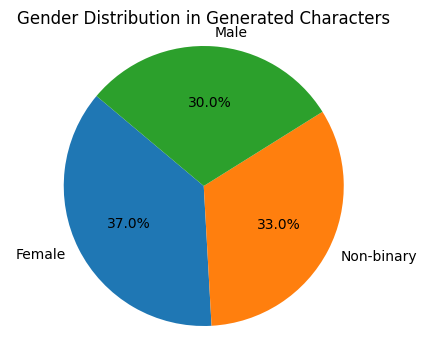

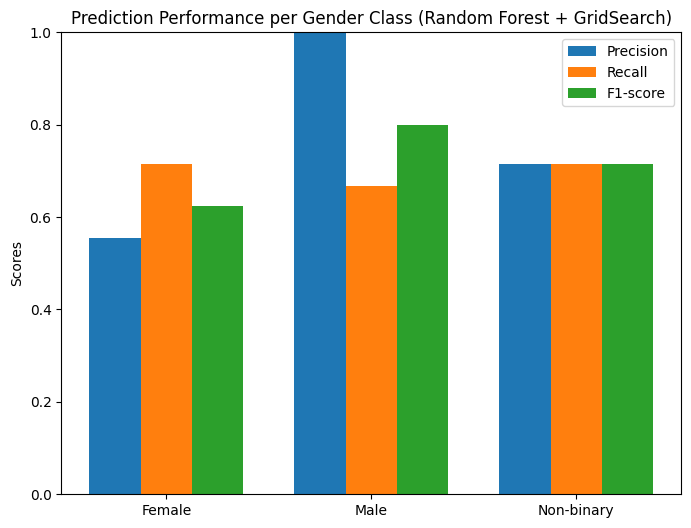

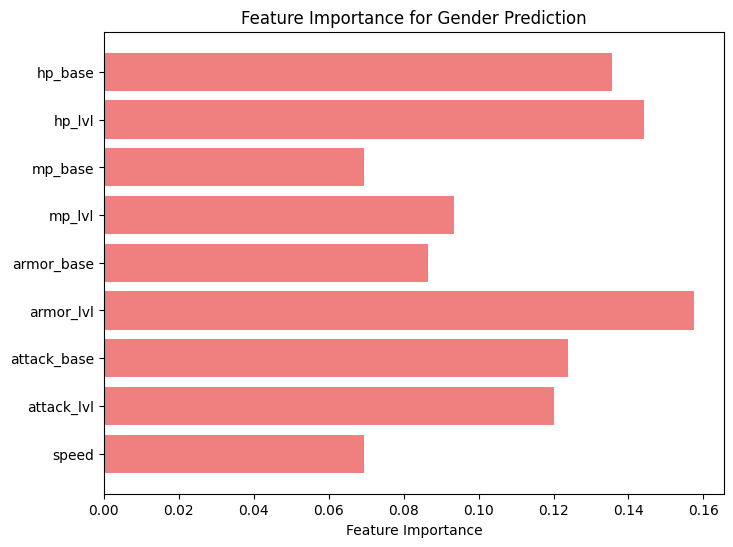

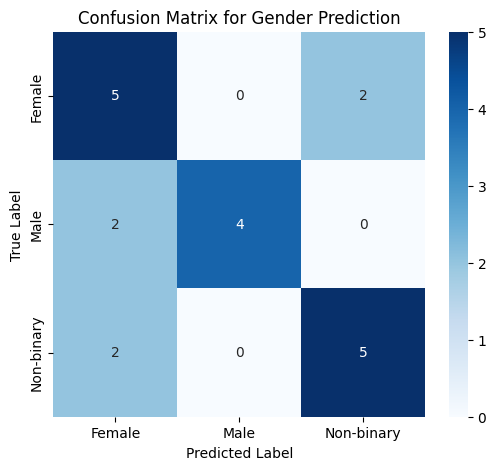

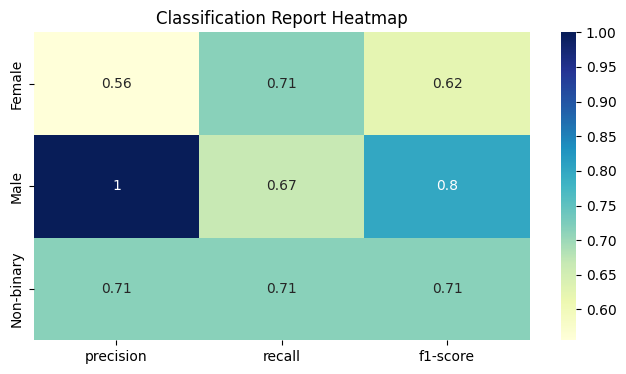

In [ ]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support, confusion_matrix
from sklearn.utils import resample

df = pd.read_csv('data1.csv')
df['stats'] = df['stats'].apply(ast.literal_eval)
stats_df = pd.json_normalize(df['stats'])
full_df = pd.concat([df, stats_df], axis=1)

feature_cols = ['hp_base', 'hp_lvl', 'mp_base', 'mp_lvl',
                'armor_base', 'armor_lvl', 'attack_base', 'attack_lvl', 'speed']
full_df = full_df[full_df['gender'].isin(['Male', 'Female', 'Non-binary'])]

X = full_df[feature_cols]
y = full_df['gender']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

base_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(base_model, param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nInitial Gender Prediction Accuracy: {accuracy:.4f}")
print(f"Best Parameters: {grid_search.best_params_}")

report = classification_report(y_test, y_pred, target_names=le.classes_)
print(report)

gender_counts = full_df['gender'].value_counts()
plt.figure(figsize=(5,4))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Gender Distribution in Generated Characters')
plt.axis('equal')
plt.show()

precisions, recalls, f1s, _ = precision_recall_fscore_support(y_test, y_pred, labels=[0,1,2])
categories = le.classes_
x = np.arange(len(categories))
width = 0.25

plt.figure(figsize=(8,6))
plt.bar(x - width, precisions, width, label='Precision')
plt.bar(x, recalls, width, label='Recall')
plt.bar(x + width, f1s, width, label='F1-score')
plt.ylabel('Scores')
plt.title('Prediction Performance per Gender Class (Random Forest + GridSearch)')
plt.xticks(x, categories)
plt.ylim(0,1)
plt.legend()
plt.show()

importance = best_model.feature_importances_
plt.figure(figsize=(8,6))
plt.barh(feature_cols, importance, color='lightcoral')
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Gender Prediction')
plt.gca().invert_yaxis()
plt.show()

cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Gender Prediction')
plt.show()

report_dict = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).T
metrics = ['precision', 'recall', 'f1-score']
report_df_filtered = report_df.loc[le.classes_, metrics]

plt.figure(figsize=(8,4))
sns.heatmap(report_df_filtered, annot=True, cmap='YlGnBu', cbar=True)
plt.title('Classification Report Heatmap')
plt.show()


In [30]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support, confusion_matrix
from sklearn.utils import resample
df = pd.read_csv('data1.csv')
df['stats'] = df['stats'].apply(ast.literal_eval)
stats_df = pd.json_normalize(df['stats'])
full_df = pd.concat([df, stats_df], axis=1)
feature_cols = ['hp_base', 'hp_lvl', 'mp_base', 'mp_lvl',
                'armor_base', 'armor_lvl', 'attack_base', 'attack_lvl', 'speed']
full_df = full_df[full_df['gender'].isin(['Male', 'Female', 'Non-binary'])]
X = full_df[feature_cols]
y = full_df['gender']
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}
base_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(base_model, param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nInitial Gender Prediction Accuracy: {accuracy:.4f}")
print(f"Best Parameters: {grid_search.best_params_}")
report = classification_report(y_test, y_pred, target_names=le.classes_)
print(report)

Fitting 3 folds for each of 27 candidates, totalling 81 fits

Initial Gender Prediction Accuracy: 0.7000
Best Parameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

      Female       0.56      0.71      0.62         7
        Male       1.00      0.67      0.80         6
  Non-binary       0.71      0.71      0.71         7

    accuracy                           0.70        20
   macro avg       0.76      0.70      0.71        20
weighted avg       0.74      0.70      0.71        20




--- Resampling to Balance Genders ---

Balanced Gender Prediction Accuracy: 0.4000
              precision    recall  f1-score   support

      Female       0.50      0.57      0.53         7
        Male       0.38      0.50      0.43         6
  Non-binary       0.25      0.14      0.18         7

    accuracy                           0.40        20
   macro avg       0.38      0.40      0.38        20
weighted avg       0.38      0.40      0.38        20



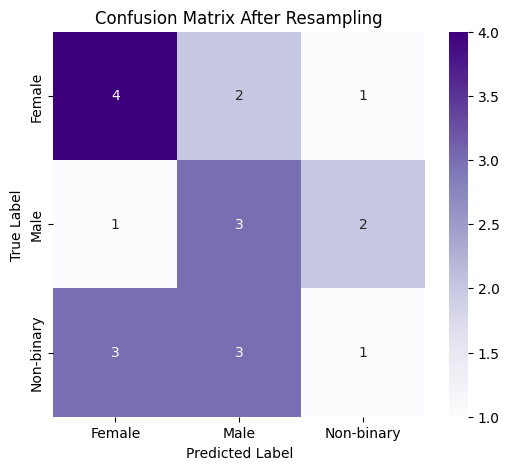

In [31]:
print("\n--- Resampling to Balance Genders ---")
train_df = pd.DataFrame(X_train, columns=feature_cols)
train_df['gender'] = y_train
dfs = []
min_count = train_df['gender'].value_counts().min()
for label in train_df['gender'].unique():
    subset = train_df[train_df['gender'] == label]
    dfs.append(resample(subset, replace=True, n_samples=min_count, random_state=42))
balanced_train_df = pd.concat(dfs)
X_train_balanced = balanced_train_df[feature_cols]
y_train_balanced = balanced_train_df['gender']
X_train_balanced_scaled = scaler.fit_transform(X_train_balanced)
best_model_balanced = RandomForestClassifier(**grid_search.best_params_, random_state=42)
best_model_balanced.fit(X_train_balanced_scaled, y_train_balanced)
y_pred_balanced = best_model_balanced.predict(X_test_scaled)
accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
print(f"\nBalanced Gender Prediction Accuracy: {accuracy_balanced:.4f}")
report_balanced = classification_report(y_test, y_pred_balanced, target_names=le.classes_)
print(report_balanced)
cm_balanced = confusion_matrix(y_test, y_pred_balanced, labels=[0, 1, 2])
plt.figure(figsize=(6,5))
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Purples', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix After Resampling')
plt.show()

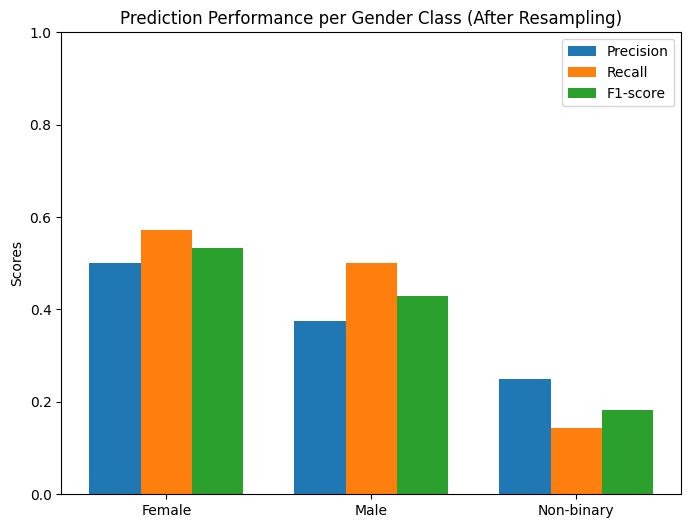

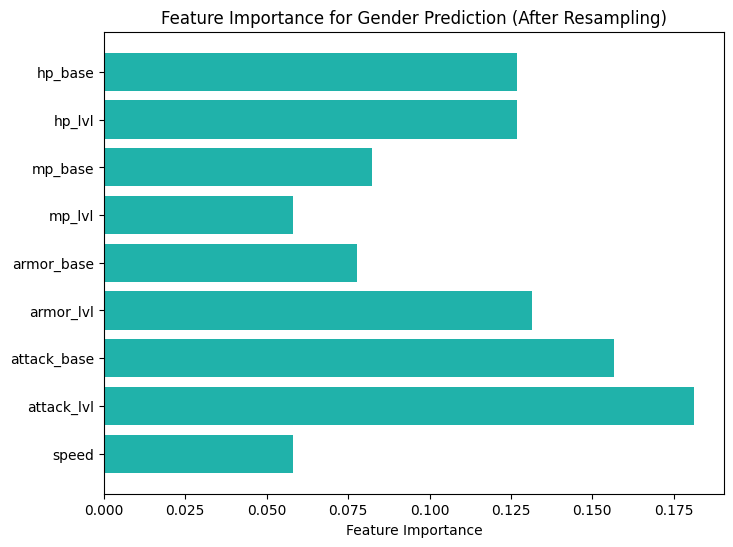

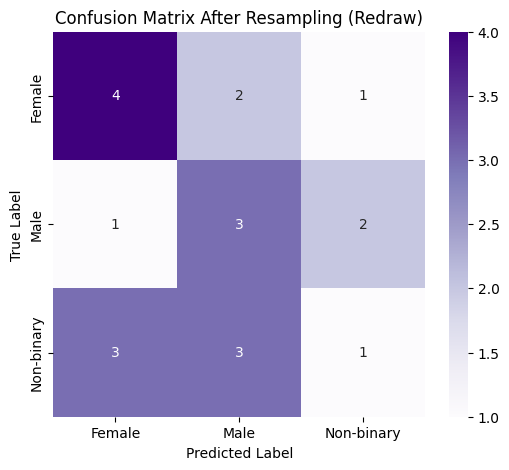

In [32]:
y_pred_balanced_labels = le.inverse_transform(y_pred_balanced)
pred_gender_counts = pd.Series(y_pred_balanced_labels).value_counts()

precisions_bal, recalls_bal, f1s_bal, _ = precision_recall_fscore_support(y_test, y_pred_balanced, labels=[0,1,2])
x = np.arange(len(categories))
width = 0.25
plt.figure(figsize=(8,6))
plt.bar(x - width, precisions_bal, width, label='Precision')
plt.bar(x, recalls_bal, width, label='Recall')
plt.bar(x + width, f1s_bal, width, label='F1-score')
plt.ylabel('Scores')
plt.title('Prediction Performance per Gender Class (After Resampling)')
plt.xticks(x, categories)
plt.ylim(0,1)
plt.legend()
plt.show()
importance_balanced = best_model_balanced.feature_importances_
plt.figure(figsize=(8,6))
plt.barh(feature_cols, importance_balanced, color='lightseagreen')
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Gender Prediction (After Resampling)')
plt.gca().invert_yaxis()
plt.show()
plt.figure(figsize=(6,5))
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Purples', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix After Resampling (Redraw)')
plt.show()